In [116]:
import sys 
sys.path.append('..')
import torch
from torch.nn.functional import one_hot
import numpy as np
import matplotlib.pyplot as plt
from random_features.polynomial_sketch import PolynomialSketch

In [38]:
import util.data

In [173]:
degree = 5
a = 4.
bias = 1.-2./a**2
lengthscale = a / np.sqrt(2.)

In [167]:
bias

0.875

In [41]:
lengthscale

2.82842712474619

In [235]:
train_data, train_labels = torch.load('../../datasets/export/fashion_mnist/pytorch/train_fashion_mnist.pth')
test_data, test_labels = torch.load('../../datasets/export/fashion_mnist/pytorch/test_fashion_mnist.pth')

In [62]:
train_data, train_labels = torch.load('../../datasets/export/mnist/pytorch/train_mnist.pth')
test_data, test_labels = torch.load('../../datasets/export/mnist/pytorch/test_mnist.pth')

In [174]:
train_data, train_labels = torch.load('../../datasets/export/adult/pytorch/train_adult.pth')
test_data, test_labels = torch.load('../../datasets/export/adult/pytorch/test_adult.pth')

In [175]:
train_data = train_data.reshape(len(train_data), -1)
test_data = test_data.reshape(len(test_data), -1)

In [176]:
# mean = train_data.mean(dim=0, keepdim=True)
# std = train_data.std(dim=0, keepdim=True)
# std[std==0] = 1.
# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std
train_data = train_data / train_data.norm(dim=1, keepdim=True)
test_data = test_data / test_data.norm(dim=1, keepdim=True)

In [177]:
indices = torch.randint(len(train_data), (1000,))
train_data = train_data[indices]
train_labels = train_labels[indices]

In [178]:
placeholder = torch.zeros(len(train_data), 127)
placeholder[:, :train_data.shape[1]] = train_data
train_data = placeholder
placeholder = torch.zeros(len(test_data), 127)
placeholder[:, :test_data.shape[1]] = test_data
test_data = placeholder

In [179]:
train_labels = one_hot(train_labels.type(torch.LongTensor)).reshape(-1, 2).type(torch.FloatTensor)
test_labels = one_hot(test_labels.type(torch.LongTensor)).reshape(-1, 2).type(torch.FloatTensor)

In [180]:
train_labels.shape

torch.Size([1000, 2])

In [181]:
def cholesky_solve(y, L):
    # L: lower triangular cholesky
    return torch.triangular_solve(
        torch.triangular_solve(y, L, upper=False)[0],
        L.conj().t(), transpose=False, upper=True
    )[0]

In [182]:
def solve_linear_regression(train_features, train_labels, test_features, lam=0.1):
    sigma_inv = train_features.t() @ train_features + torch.eye(len(train_features.t())) * lam
    xTy = train_features.t() @ train_labels
    L_sigma_inv = torch.cholesky(sigma_inv)
    alpha = cholesky_solve(xTy, L_sigma_inv)
    return test_features @ alpha

In [183]:
real_errors = []
comp_errors = []

real_accs = []
comp_accs = []

for degree in [degree]:
    print('Degree', degree)
    real_errors_cur = []
    comp_errors_cur = []
    
    real_accs_cur = []
    comp_accs_cur = []
    
    for seed in range(20):

        # real sketch
        feature_encoder = PolynomialSketch(
            127, # data input dimension (power of 2 for srht projection_type)
            256, # output dimension of the random sketch
            degree=degree, # degree of the polynomial kernel
            bias=bias, # bias parameter of the polynomial kernel
            lengthscale=lengthscale, # inverse scale of the data (like lengthscale for Gaussian kernel)
            projection_type='rademacher',
            hierarchical=False,
            complex_weights=False
        )

        feature_encoder.resample()
        projections_train = feature_encoder.forward(train_data)
        projections_test = feature_encoder.forward(test_data)
        approx_kernel_real = projections_train @ projections_train.t()
        predictions_real = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)

        # complex sketch
        feature_encoder = PolynomialSketch(
            127, # data input dimension (power of 2 for srht projection_type)
            256, # output dimension of the random sketch
            degree=degree, # degree of the polynomial kernel
            bias=bias, # bias parameter of the polynomial kernel
            lengthscale=lengthscale, # inverse scale of the data (like lengthscale for Gaussian kernel)
            projection_type='rademacher',
            hierarchical=False,
            complex_weights=True
        )

        feature_encoder.resample()
        projections_train = feature_encoder.forward(train_data)
        projections_test = feature_encoder.forward(test_data)
        projections_train = torch.hstack([projections_train.real, projections_train.imag])
        projections_test = torch.hstack([projections_test.real, projections_test.imag])
        
        predictions_comp = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)
        approx_kernel_comp = projections_train @ projections_train.t()

        # reference kernel
        ref_kernel = (bias + (train_data/lengthscale) @ (train_data/lengthscale).t())**degree

        # error
        real_error = (approx_kernel_real - ref_kernel).pow(2).sum().sqrt()
        real_error /= ref_kernel.pow(2).sum().sqrt()

        comp_error = (approx_kernel_comp - ref_kernel).pow(2).sum().sqrt()
        comp_error /= ref_kernel.pow(2).sum().sqrt()

        real_errors_cur.append(real_error.item())
        comp_errors_cur.append(comp_error.item())
        
        real_acc = (predictions_real.argmax(dim=1) == test_labels.argmax(dim=1)).sum() / len(test_labels)
        comp_acc = (predictions_comp.argmax(dim=1) == test_labels.argmax(dim=1)).sum() / len(test_labels)
        
        real_accs_cur.append(real_acc.item())
        comp_accs_cur.append(comp_acc.item())
        
    real_errors.append(np.array(real_errors_cur))
    comp_errors.append(np.array(comp_errors_cur))
    
    real_accs.append(np.array(real_accs_cur))
    comp_accs.append(np.array(comp_accs_cur))

Degree 5


In [184]:
np.mean(np.array(real_errors), axis=1)

array([0.11639001])

In [185]:
np.mean(np.array(comp_errors), axis=1)

array([0.06811456])

In [186]:
np.mean(np.array(real_accs), axis=1)

array([0.77526258])

In [187]:
np.mean(np.array(comp_accs), axis=1)

array([0.77533014])

In [13]:
def var_real(X, p=1):
    # sum(x_i y_i)
    dot_product = X @ X.t()
    # sum(x_i^2 y_i^2)
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    # ||x||^2 ||y||^2
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    moment_real = (norms_squared + 2 * (dot_product**2 - squared_dot_product))
    
    return 0.5*(moment_real**p - dot_product**(2*p))

In [14]:
def var_difference(X, p=1):
    # sum(x_i y_i)
    dot_product = X @ X.t()
    # sum(x_i^2 y_i^2)
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    # ||x||^2 ||y||^2
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    moment_real = (norms_squared + 2 * (dot_product**2 - squared_dot_product))
    moment_comp_abs = (norms_squared + dot_product**2 - squared_dot_product)
    moment_comp_re = (2 * dot_product**2 - squared_dot_product)
    
    var_dif = 0.5*(moment_real**p - moment_comp_abs**p - moment_comp_re**p + dot_product**(2*p))
    
    return var_dif

In [26]:
X = torch.rand(1000, 100)
X = X / X.norm(dim=1, keepdim=True)
#X[:len(X)//2]*=10

In [27]:
(var_difference(X, 1) < 0).sum() / len(X)**2

tensor(0.4055)

In [28]:
(var_difference(X, 2) < 0).sum() / len(X)**2

tensor(0.)

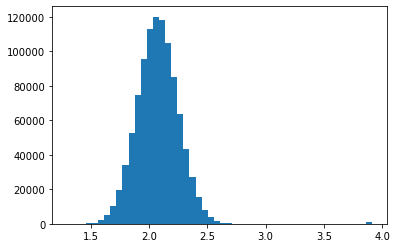

In [29]:
plt.hist(var_real(X, 2).view(-1).numpy(), bins=50)
plt.show()

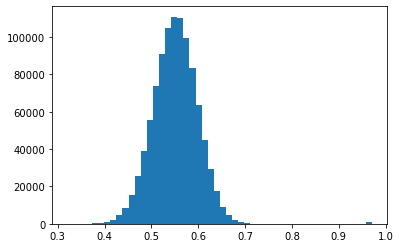

In [30]:
plt.hist(var_difference(X, 2).view(-1).numpy(), bins=50)
plt.show()

In [31]:
(var_difference(X, 3) < 0).sum() / len(X)**2

tensor(0.)

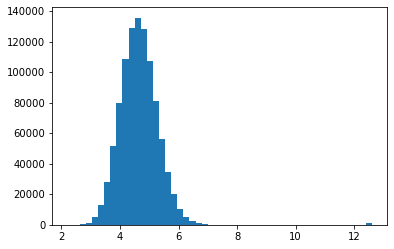

In [32]:
plt.hist(var_real(X, 3).view(-1).numpy(), bins=50)
plt.show()

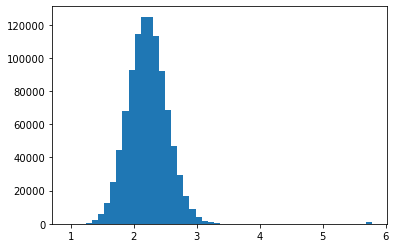

In [33]:
plt.hist(var_difference(X, 3).view(-1).numpy(), bins=50)
plt.show()

In [34]:
(var_difference(X, 4) < 0).sum() / len(X)**2

tensor(0.)

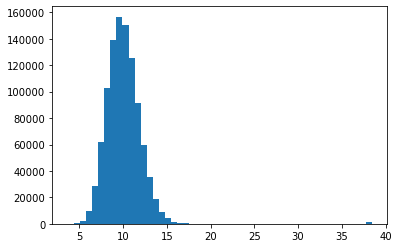

In [35]:
plt.hist(var_real(X, 4).view(-1).numpy(), bins=50)
plt.show()

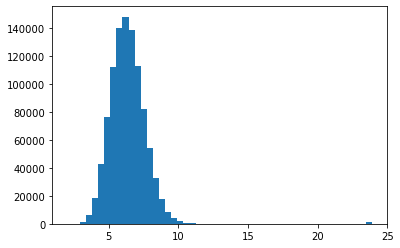

In [36]:
plt.hist(var_difference(X, 4).view(-1).numpy(), bins=50)
plt.show()